# Steps: 
10. Conclude, interpret
11. Make more visualizations
12. Blog about it
13. Where do we go from here? 
14. What is the "so what"? 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import table
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
import numpy as np

In [3]:
#file path for data: capstone/using-AI-to-predict-dog-licenses/data
#open raw_data.csv

In [4]:
df = pd.read_csv('/content/drive/MyDrive/raw_data.csv')

In [5]:
df.set_index('ValidDate', inplace = True)

In [6]:
df = df.drop(['ExpYear'], axis = 1)

In [7]:
df.head()

,LicenseType,Breed,Color,DogName,OwnerZip
ValidDate,,,,,
2014-12-02 09:40:53,Dog Individual Neutered Male,COCKAPOO,BROWN,CHARLEY,15236
2014-12-02 09:45:25,Dog Senior Citizen or Disability Neutered Male,GER SHEPHERD,BLACK/BROWN,TACODA,15238
2014-12-02 09:47:55,Dog Individual Spayed Female,GER SHEPHERD,BLACK,CHARLY,15205
2014-12-02 10:02:33,Dog Individual Spayed Female,LABRADOR RETRIEVER,BLACK,ABBEY,15143
2014-12-02 10:05:50,Dog Individual Female,GER SHORTHAIR POINT,BROWN,CHARLEY,15228


In [8]:
df['Breed'].value_counts().sum()

286724

In [9]:
len(df['Breed'].unique())

340

In [10]:
#I would definitely need to look at cutting that number down- that would be way too noisy.
#My initial thought is to see what the top 10 breeds are
#Maybe from there I can either to dummies or aggregate

In [11]:
top_ten = df['Breed'].value_counts()[:11]

In [12]:
top_ten
#bar chart here

MIXED                  29009
LABRADOR RETRIEVER     19713
LAB MIX                17714
GOLDEN RETRIEVER        9344
GER SHEPHERD            8437
SHIH TZU                7976
BEAGLE                  7960
CHIHUAHUA               7664
TAG                     7475
AM PIT BULL TERRIER     7332
YORKSHIRE TERRIER       6268
Name: Breed, dtype: int64

In [13]:
top_ten_bar = pd.DataFrame(top_ten)
top_ten_bar.head()

,Breed
MIXED,29009
LABRADOR RETRIEVER,19713
LAB MIX,17714
GOLDEN RETRIEVER,9344
GER SHEPHERD,8437


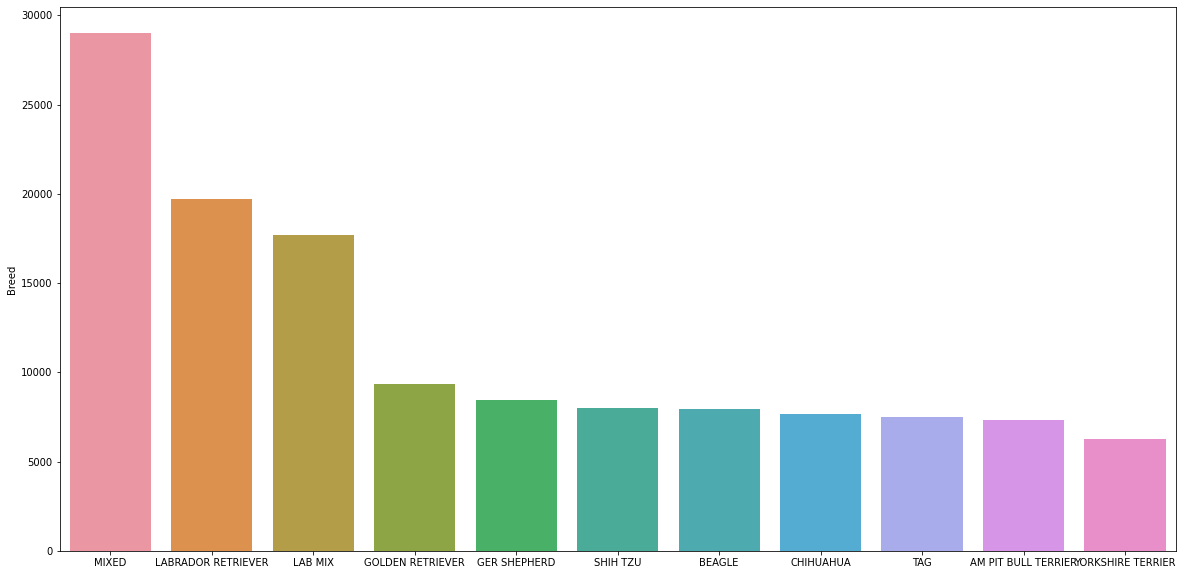

In [14]:
fig = plt.figure(figsize = (20, 10))
bar = sns.barplot(top_ten_bar.index, top_ten_bar.Breed)

In [15]:
#TAG is not a type of dog. they are denoting that they are putting tags on an existing dog

In [16]:
tag_df = df.loc[df['Breed'] == 'TAG']
tag_df.loc[(tag_df['DogName'] == 'SHADOW') & (tag_df['OwnerZip'] == 15102)]

,LicenseType,Breed,Color,DogName,OwnerZip
ValidDate,,,,,
2015-03-12 11:11:36,Dog Individual Spayed Female,TAG,BLACK,SHADOW,15102
2017-01-10 09:39:46,Dog Individual Spayed Female,TAG,BLACK,SHADOW,15102
2015-12-11 10:35:08,Dog Individual Spayed Female,TAG,BLACK,SHADOW,15102


In [17]:
a = len(tag_df['DogName'])
b = len(tag_df['DogName'].value_counts())
a-b

5708

In [18]:
#Purpose: predict licenses dispensed while considering extra variables. 
#I think top 10 dummies is actually going to benefit me most. 
#Let's start with breed: top 9 and 'other'
## investigate whether an 'other' column is going to unbalance the data too bad; 
#we may need to keep it to top 10 with a disclaimer

In [19]:
df.head()

,LicenseType,Breed,Color,DogName,OwnerZip
ValidDate,,,,,
2014-12-02 09:40:53,Dog Individual Neutered Male,COCKAPOO,BROWN,CHARLEY,15236
2014-12-02 09:45:25,Dog Senior Citizen or Disability Neutered Male,GER SHEPHERD,BLACK/BROWN,TACODA,15238
2014-12-02 09:47:55,Dog Individual Spayed Female,GER SHEPHERD,BLACK,CHARLY,15205
2014-12-02 10:02:33,Dog Individual Spayed Female,LABRADOR RETRIEVER,BLACK,ABBEY,15143
2014-12-02 10:05:50,Dog Individual Female,GER SHORTHAIR POINT,BROWN,CHARLEY,15228


In [20]:
df.isnull().sum()

LicenseType    0
Breed          0
Color          0
DogName        0
OwnerZip       0
dtype: int64

In [21]:
breed_df = pd.DataFrame(df.Breed)
breed_df.set_index(breed_df.index, inplace = True)
breed_df.index = pd.to_datetime(breed_df.index)

MIXED
LABRADOR RETRIEVER     
LAB MIX                
GOLDEN RETRIEVER        
GER SHEPHERD            
SHIH TZU            
BEAGLE                  
CHIHUAHUA                                  
AM PIT BULL TERRIER     
YORKSHIRE TERRIER      

In [22]:
df_top_ten = breed_df[(breed_df['Breed'] == 'MIXED') |
                     (breed_df['Breed'] == 'LABRADOR RETRIEVER') |
                     (breed_df['Breed'] == 'LAB MIX') |
                     (breed_df['Breed'] == 'GOLDEN RETRIEVER') |
                     (breed_df['Breed'] == 'GER SHEPHERD') |
                     (breed_df['Breed'] == 'SHIH TZU') |
                     (breed_df['Breed'] == 'BEAGLE') |
                     (breed_df['Breed'] == 'CHIHUAHUA') |
                     (breed_df['Breed'] == 'AM PIT BULL TERRIER')|
                     (breed_df['Breed'] == 'YORKSHIRE TERRIER')]
df_top_ten.head()

,Breed
ValidDate,
2014-12-02 09:45:25,GER SHEPHERD
2014-12-02 09:47:55,GER SHEPHERD
2014-12-02 10:02:33,LABRADOR RETRIEVER
2014-12-02 10:08:13,YORKSHIRE TERRIER
2014-12-02 10:15:30,YORKSHIRE TERRIER


In [23]:
print("Breed df: ", len(breed_df))
print("Top Ten df: ", len(df_top_ten))
print("Difference: ", len(breed_df)-len(df_top_ten))

Breed df:  286724
Top Ten df:  121417
Difference:  165307


In [24]:
#the difference is substantial- let's look at top 10

In [25]:
ten_dummies = pd.get_dummies(df_top_ten['Breed'])
ten_dummies.head()

,AM PIT BULL TERRIER,BEAGLE,CHIHUAHUA,GER SHEPHERD,GOLDEN RETRIEVER,LAB MIX,LABRADOR RETRIEVER,MIXED,SHIH TZU,YORKSHIRE TERRIER
ValidDate,,,,,,,,,,
2014-12-02 09:45:25,0,0,0,1,0,0,0,0,0,0
2014-12-02 09:47:55,0,0,0,1,0,0,0,0,0,0
2014-12-02 10:02:33,0,0,0,0,0,0,1,0,0,0
2014-12-02 10:08:13,0,0,0,0,0,0,0,0,0,1
2014-12-02 10:15:30,0,0,0,0,0,0,0,0,0,1


In [26]:
breed = ten_dummies.resample('B').sum()
breed.head()

,AM PIT BULL TERRIER,BEAGLE,CHIHUAHUA,GER SHEPHERD,GOLDEN RETRIEVER,LAB MIX,LABRADOR RETRIEVER,MIXED,SHIH TZU,YORKSHIRE TERRIER
ValidDate,,,,,,,,,,
2014-12-02,2.0,1.0,1.0,4.0,2.0,3.0,9.0,10.0,1.0,3.0
2014-12-03,6.0,8.0,2.0,3.0,8.0,17.0,12.0,40.0,2.0,3.0
2014-12-04,5.0,7.0,2.0,7.0,17.0,17.0,29.0,51.0,12.0,13.0
2014-12-05,4.0,2.0,5.0,2.0,9.0,10.0,10.0,21.0,5.0,3.0
2014-12-08,5.0,5.0,8.0,11.0,9.0,14.0,23.0,47.0,8.0,10.0


In [27]:
breed['Total'] = breed.sum(axis = 1)
breed.head()

,AM PIT BULL TERRIER,BEAGLE,CHIHUAHUA,GER SHEPHERD,GOLDEN RETRIEVER,LAB MIX,LABRADOR RETRIEVER,MIXED,SHIH TZU,YORKSHIRE TERRIER,Total
ValidDate,,,,,,,,,,,
2014-12-02,2.0,1.0,1.0,4.0,2.0,3.0,9.0,10.0,1.0,3.0,36.0
2014-12-03,6.0,8.0,2.0,3.0,8.0,17.0,12.0,40.0,2.0,3.0,101.0
2014-12-04,5.0,7.0,2.0,7.0,17.0,17.0,29.0,51.0,12.0,13.0,160.0
2014-12-05,4.0,2.0,5.0,2.0,9.0,10.0,10.0,21.0,5.0,3.0,71.0
2014-12-08,5.0,5.0,8.0,11.0,9.0,14.0,23.0,47.0,8.0,10.0,140.0


In [28]:
breed.to_csv('drive/MyDrive/breed_daily_totals.csv')

In [29]:
#next I would like to get a pretty visualization of this- a colorful line chart

In [66]:
line = breed.drop(columns = 'Total', axis = 0)
line.head()

,AM PIT BULL TERRIER,BEAGLE,CHIHUAHUA,GER SHEPHERD,GOLDEN RETRIEVER,LAB MIX,LABRADOR RETRIEVER,MIXED,SHIH TZU,YORKSHIRE TERRIER
ValidDate,,,,,,,,,,
2014-12-02,2.0,1.0,1.0,4.0,2.0,3.0,9.0,10.0,1.0,3.0
2014-12-03,6.0,8.0,2.0,3.0,8.0,17.0,12.0,40.0,2.0,3.0
2014-12-04,5.0,7.0,2.0,7.0,17.0,17.0,29.0,51.0,12.0,13.0
2014-12-05,4.0,2.0,5.0,2.0,9.0,10.0,10.0,21.0,5.0,3.0
2014-12-08,5.0,5.0,8.0,11.0,9.0,14.0,23.0,47.0,8.0,10.0


In [88]:
pitbull = breed['AM PIT BULL TERRIER'].values
beagle = breed['BEAGLE'].values
chihuahua = breed['CHIHUAHUA'].values
shepherd = breed['GER SHEPHERD'].values
retriever = breed['GOLDEN RETRIEVER'].values
lab_mix = breed['LAB MIX'].values
lab_retriever = breed['LABRADOR RETRIEVER'].values
mixed = breed['MIXED'].values
shitzu = breed['SHIH TZU']
yorkie = breed['YORKSHIRE TERRIER']

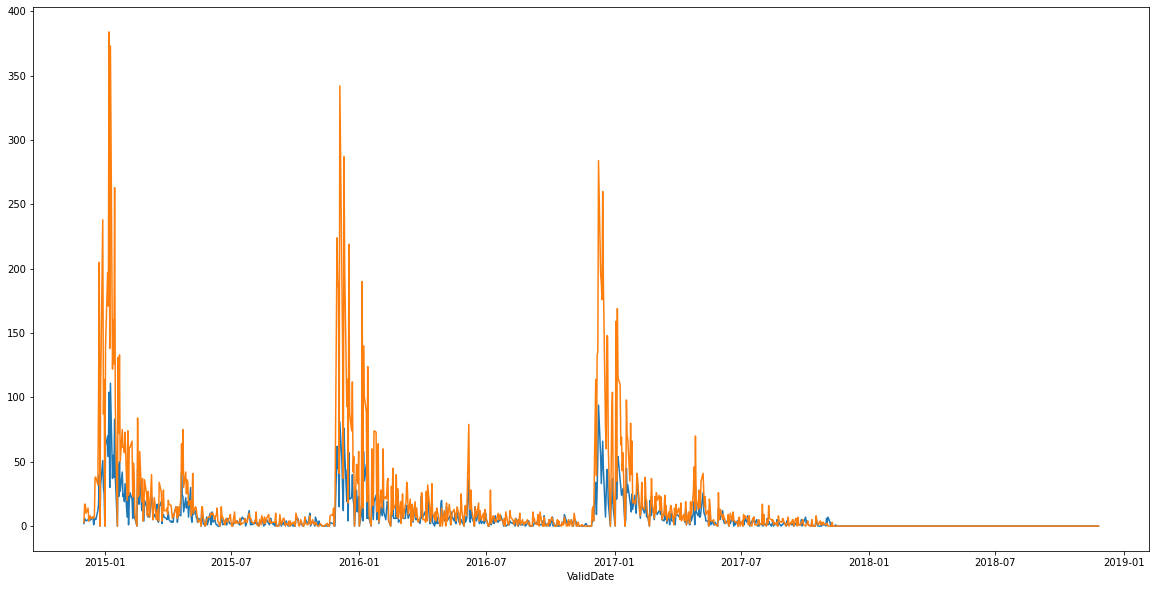

In [92]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
line_plot = sns.lineplot(line.index, pitbull)
exp = sns.lineplot(line.index, lab_mix)
#this is going to look v noisy...

In [30]:
#run model on just top 10, determine the importance of dog breed in prediction
#if it's highly correlated, consider 'other' column, or even 340 dummies? 
#future work idea ^

## Scaling Data

In [31]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(breed.values)

series_to_supervise function courtesy of Jason Brownlee with Machine Learning Mastery

In [32]:
def series_to_supervise(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d' % (j+1)) for j in range(n_vars)]
        else: 
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [33]:
#start with lag of 1
lstm_df = series_to_supervise(scaled_df)
lstm_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11
1,0.018018,0.004831,0.007194,0.023256,0.008475,0.007812,0.020045,0.012690,0.005128,0.019737,0.013025,0.054054,0.038647,0.014388,0.017442,0.033898,0.044271,0.026726,0.050761,0.010256,0.019737,0.036541
2,0.054054,0.038647,0.014388,0.017442,0.033898,0.044271,0.026726,0.050761,0.010256,0.019737,0.036541,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887
3,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687
4,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651
5,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517


In [34]:
lstm_df.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7',
       'var8', 'var9', 'var10', 'var11'],
      dtype='object')

In [35]:
lstm_df.drop(lstm_df.columns[[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]], axis = 1, inplace = True)
lstm_df.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var11'],
      dtype='object')

In [36]:
#train_test_split
X = lstm_df[lstm_df.columns[:10]].values
y = lstm_df['var11'].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [38]:
print("X_train: ",X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (727, 10)
X_test:  (312, 10)
Y_train:  (727,)
y_test:  (312,)


In [39]:
#Reshape into a 3D that LSTM expects
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape)
print(X_test.shape)

(727, 1, 10)
(312, 1, 10)


In [40]:
np.save("drive/MyDrive/X_train", X_train)
np.save("drive/MyDrive/X_test", X_test)

In [41]:
np.save("drive/MyDrive/y_train", y_train)
np.save("drive/MyDrive/y_test", y_test)

In [42]:
#Because I have already done the work of optimizing the sum for LSTM, I'll use the optimal model from the univariate
#I can always go back and tune further
#Must adjust data to 5 lags

In [43]:
lag_5 = series_to_supervise(scaled_df, 5, 1)
lag_5.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11
5,0.018018,0.004831,0.007194,0.023256,0.008475,0.007812,0.020045,0.012690,0.005128,0.019737,0.013025,0.054054,0.038647,0.014388,0.017442,0.033898,0.044271,0.026726,0.050761,0.010256,0.019737,0.036541,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517
6,0.054054,0.038647,0.014388,0.017442,0.033898,0.044271,0.026726,0.050761,0.010256,0.019737,0.036541,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517,0.036036,0.009662,0.007194,0.005814,0.012712,0.013021,0.013363,0.013959,0.010256,0.013158,0.013386
7,0.045045,0.033816,0.014388,0.040698,0.072034,0.044271,0.064588,0.064721,0.061538,0.085526,0.057887,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517,0.036036,0.009662,0.007194,0.005814,0.012712,0.013021,0.013363,0.013959,0.010256,0.013158,0.013386,0.054054,0.000000,0.000000,0.023256,0.029661,0.020833,0.020045,0.013959,0.020513,0.006579,0.018090
8,0.036036,0.009662,0.035971,0.011628,0.038136,0.026042,0.022272,0.026650,0.025641,0.019737,0.025687,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517,0.036036,0.009662,0.007194,0.005814,0.012712,0.013021,0.013363,0.013959,0.010256,0.013158,0.013386,0.054054,0.000000,0.000000,0.023256,0.029661,0.020833,0.020045,0.013959,0.020513,0.006579,0.018090,0.045045,0.009662,0.021583,0.023256,0.012712,0.015625,0.011136,0.011421,0.010256,0.013158,0.014834
9,0.045045,0.024155,0.057554,0.063953,0.038136,0.036458,0.051225,0.059645,0.041026,0.065789,0.050651,0.054054,0.028986,0.014388,0.040698,0.029661,0.010417,0.026726,0.020305,0.015385,0.013158,0.023517,0.036036,0.009662,0.007194,0.005814,0.012712,0.013021,0.013363,0.013959,0.010256,0.013158,0.013386,0.054054,0.000000,0.000000,0.023256,0.029661,0.020833,0.020045,0.013959,0.020513,0.006579,0.018090,0.045045,0.009662,0.021583,0.023256,0.012712,0.015625,0.011136,0.011421,0.010256,0.013158,0.014834,0.063063,0.019324,0.007194,0.011628,0.016949,0.018229,0.006682,0.020305,0.010256,0.013158,0.017366


In [44]:
lag_5.columns

Index(['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       'var11(t-5)', 'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)',
       'var5(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)',
       'var10(t-4)', 'var11(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)',
       'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)',
       'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)',
       'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)',
       'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9',
       'var10', 'var11'],
      dtype='object')

In [45]:
lag_5.drop(lag_5.columns[[55, 56, 57, 58, 59, 60, 61, 62, 63, 64]], axis = 1, inplace = True)
lag_5.columns

Index(['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)',
       'var11(t-5)', 'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)',
       'var5(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)',
       'var10(t-4)', 'var11(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)',
       'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)',
       'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var1(t-2)', 'var2(t-2)',
       'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)',
       'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var1(t-1)',
       'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)',
       'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)',
       'var11'],
      dtype='object')

In [46]:
len(lag_5.columns)

56

In [47]:
X_5 = lag_5[lag_5.columns[:55]].values
y_5 = lag_5['var11'].values

In [48]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X_5, y_5, test_size = 0.3, random_state = 42)

In [49]:
print("X5_train: ",X5_train.shape)
print("X5_test: ", X5_test.shape)
print("Y5_train: ", y5_train.shape)
print("y5_test: ", y5_test.shape)

X5_train:  (724, 55)
X5_test:  (311, 55)
Y5_train:  (724,)
y5_test:  (311,)


In [50]:
X5_train = X5_train.reshape((X5_train.shape[0], 5, 11))
X5_test = X5_test.reshape((X5_test.shape[0], 5, 11))
print(X5_train.shape)
print(X5_test.shape)

(724, 5, 11)
(311, 5, 11)


In [51]:
np.save("drive/MyDrive/X5_train", X5_train)
np.save("drive/MyDrive/X5_test", X5_test)

In [52]:
#same model from univariate experiment
now = datetime.datetime.now()
model_5 = Sequential()
model_5.add(LSTM(50, input_shape = (X5_train.shape[1], X5_train.shape[2])))
model_5.add(Dense(50, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(35, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(20, activation = 'tanh'))
model_5.add(Dropout(0.3))
model_5.add(Dense(1))
model_5.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

history_5 = model_5.fit(X5_train, y5_train, epochs = 10, batch_size = 20, validation_data = (X5_test, y5_test),
                        verbose = True, shuffle = False)
later = datetime.datetime.now()
elapsed = later - now
print('Time elapsed: ', elapsed)

Epoch 1/10
37/37 [==============================] - 3s 29ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 2/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 3/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 4/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 5/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 6/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/10
37/37 [==============================] - 0s 6ms/step - loss: 0.0036 - mse: 0.0

In [53]:
model_5.save('drive/MyDrive/model_5')

INFO:tensorflow:Assets written to: drive/MyDrive/model_5/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_5/assets


In [54]:
#examine and analyze these results- let's see what's up!

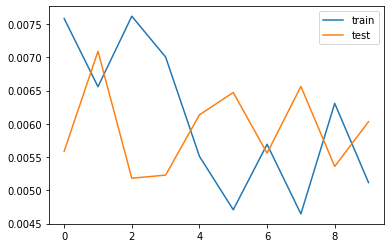

In [55]:
plt.plot(history_5.history['loss'], label = 'train')
plt.plot(history_5.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [56]:
#making predictions 
yhat = model_5.predict(X5_test)
X5_test = X5_test.reshape((X5_test.shape[0], 55))
inv_yhat = np.concatenate((yhat, X5_test[:, -10:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

y5_test = y5_test.reshape((len(y5_test), 1))
inv_y = np.concatenate((y5_test, X5_test[:, -10:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

mse = mean_squared_error(inv_y, inv_yhat)
print('MSE of prediction: ', np.round(mse, 2))

MSE of prediction:  74.34


It was originally intended to follow this model up with an exploration of the recursive prediction function used in the univariate model. This proved to be beyond the scope of this project. For a more complete look  at how this was ascertained, please see the notebook entitled "Multivariate Prediction Function" in this same repo. 

In [57]:
#draw conclusions
#next steps
#clean up notebook
#create more visualizations
#create presentation, record